<a href="https://colab.research.google.com/github/daferocu/Topicos-Avanzados/blob/main/datalab/Proyecto%202/P1_MovieGenrePrediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification**

**Proyecto Procesamiento de Lenguaje Natural - NLP**

**Profesor:** Sergio Alberto Mora Pardo

**Integrantes:**

*   Daniel Rodríguez
*   Diana Ibáñez
*   Oscar Correcha
*   Erika Cárdenas
*   Paola Castro


**Objetivo:**
Clasificar el género de la película según su trama.

<img src="https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/moviegenre.png"
     style="float: left; margin-right: 10px;" />



### Data

*Input:*
- movie plot

*Output:*
Probability of the movie belong to each genre


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [ ]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.multioutput import ClassifierChain
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from funciones_auxiliares import print_metrics, comparar_metricas, grafico_metricas, comparar_listas_anidadas

import warnings
warnings.filterwarnings("ignore")

# **1. Adquisición de los datos**

In [2]:
dataTraining = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

dataTraining = dataTraining.drop_duplicates()
dataTraining['plot'] = dataTraining['title'] + ' ' + dataTraining['plot']
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [3]:
# # Guarda el MultiLabelBinarizer en un archivo pickle
# with open('le.pkl', 'wb') as f:
#     pickle.dump(le, f)

In [3]:
max_f = 2500
test_size = 0.2
random_state = 42

def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [4]:
vect = TfidfVectorizer(ngram_range=(1, 3), analyzer='word', lowercase = True, 
                       tokenizer=tokenize, stop_words='english',
                       strip_accents='unicode', use_idf=True, min_df=10)

X_dtm = vect.fit_transform(dataTraining['plot'])
print(X_dtm.shape)

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, 
                                                                  y_genres, 
                                                                  test_size=test_size, 
                                                                  random_state=random_state)

(7894, 7075)


In [6]:
# pickle.dump(vect.vocabulary_, open("feature.pkl", "wb"))

### Experimentos

In [7]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=random_state))
clf.fit(X_train, y_train_genres)
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)
model1_metrics = print_metrics('RandomForestClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - RandomForestClassifier:

      AUC entrenamiento: 0.970
      AUC testeo: 0.824


In [8]:
Mnb_classifier = OneVsRestClassifier(MultinomialNB(alpha=0.1, fit_prior=False))
Mnb_classifier.fit(X_train, y_train_genres)
y_pred_genres = Mnb_classifier.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)
model2_metrics = print_metrics('MultinomialNB', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - MultinomialNB:

      AUC entrenamiento: 0.970
      AUC testeo: 0.824


In [9]:
# pickle_out = open("cl_nb.pkl","wb")
# pickle.dump(Mnb_classifier, pickle_out)
# pickle_out.close()

In [10]:
ovr = OneVsRestClassifier(XGBClassifier())
ovr.fit(X_train, y_train_genres)
y_pred_genres = ovr.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = ovr.predict_proba(X_train)
y_pred_test = ovr.predict_proba(X_test)
model3_metrics = print_metrics('XGBClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - XGBClassifier:

      AUC entrenamiento: 0.996
      AUC testeo: 0.838


In [5]:
lr = OneVsRestClassifier(LogisticRegression(random_state=random_state))
lr.fit(X_train, y_train_genres)
y_pred_genres = lr.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = lr.predict_proba(X_train)
y_pred_test = lr.predict_proba(X_test)
model4_metrics = print_metrics('LogisticRegression', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - LogisticRegression:

      AUC entrenamiento: 0.981
      AUC testeo: 0.891


In [12]:
# pickle_out = open("cl_lr.pkl","wb")
# pickle.dump(lr, pickle_out)
# pickle_out.close()

In [9]:
lr = OneVsRestClassifier(LogisticRegressionCV(random_state=random_state, cv=5))
lr.fit(X_train, y_train_genres)
y_pred_genres = lr.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = lr.predict_proba(X_train)
y_pred_test = lr.predict_proba(X_test)
model5_metrics = print_metrics('LogisticRegressionCV', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - LogisticRegressionCV:

      AUC entrenamiento: 0.990
      AUC testeo: 0.881


In [10]:
sg = OneVsRestClassifier(SGDClassifier(random_state=random_state))
sg.fit(X_train, y_train_genres)
y_pred_genres = sg.predict(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = sg.predict(X_train)
y_pred_test = sg.predict(X_test)
model6_metrics = print_metrics('SGDClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - SGDClassifier:

      AUC entrenamiento: 0.894
      AUC testeo: 0.638


In [11]:
svmm = OneVsRestClassifier(LinearSVC(random_state=random_state))
svmm.fit(X_train, y_train_genres)
y_pred_genres = svmm.predict(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = svmm.predict(X_train)
y_pred_test = svmm.predict(X_test)
model7_metrics = print_metrics('LinearSVC', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - LinearSVC:

      AUC entrenamiento: 0.979
      AUC testeo: 0.638


In [12]:
ab_clf = OneVsRestClassifier(AdaBoostClassifier())
ab_clf.fit(X_train, y_train_genres)
y_pred_genres = ab_clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = ab_clf.predict_proba(X_train)
y_pred_test = ab_clf.predict_proba(X_test)
model8_metrics = print_metrics('AdaBoostClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - AdaBoostClassifier:

      AUC entrenamiento: 0.916
      AUC testeo: 0.793


In [13]:
gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train, y_train_genres)
y_pred_genres = gb_clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = gb_clf.predict_proba(X_train)
y_pred_test = gb_clf.predict_proba(X_test)
model9_metrics = print_metrics('GradientBoostingClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - GradientBoostingClassifier:

      AUC entrenamiento: 0.956
      AUC testeo: 0.770


In [14]:
base_classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state))
classifier_chain = ClassifierChain(base_classifier, order="random", random_state=random_state)
classifier_chain.fit(X_train, y_train_genres)
y_pred_genres = lr.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = classifier_chain.predict_proba(X_train)
y_pred_test = classifier_chain.predict_proba(X_test)
model10_metrics = print_metrics('ClassifierChain', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - ClassifierChain:

      AUC entrenamiento: 0.953
      AUC testeo: 0.848


In [15]:
n_scores = cross_val_score(classifier_chain, X_train, y_train_genres, 
                           scoring='roc_auc_ovr', cv=5, 
                           n_jobs=-1)
n_scores = np.absolute(n_scores)
n_scores

array([0.83780427, 0.83983655, 0.8518849 , 0.83971094,        nan])

In [16]:
kk = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 3))
kk.fit(X_train, y_train_genres)
y_pred_genres = kk.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

y_pred_train = kk.predict_proba(X_train)
y_pred_test = kk.predict_proba(X_test)
model11_metrics = print_metrics('KNeighborsClassifier', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - KNeighborsClassifier:

      AUC entrenamiento: 0.954
      AUC testeo: 0.654


In [17]:
base_classifier = RandomForestClassifier(random_state=42)
classifier_chain = ClassifierChain(base_classifier, order="random")
classifier_chain.fit(X_train, y_train_genres)
y_pred_genres = classifier_chain.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')


y_pred_train = classifier_chain.predict_proba(X_train)
y_pred_test = classifier_chain.predict_proba(X_test)
model12_metrics = print_metrics('ClassifierChain2', 
                               y_pred_train, y_pred_test, 
                               y_train_genres, y_test_genres
                               )


The results of the adjustment metrics - ClassifierChain2:

      AUC entrenamiento: 1.000
      AUC testeo: 0.811


## Modelos metricas

In [18]:
metricas_tabla = comparar_metricas(model1_metrics,
                                   model2_metrics,
                                   model3_metrics,
                                   model4_metrics,
                                   model5_metrics,
                                   model6_metrics,
                                   model7_metrics,
                                   model8_metrics,
                                   model9_metrics,
                                   model10_metrics,
                                   model11_metrics,
                                   model12_metrics,
                                   index_name='Modelo')
metricas_tabla

,Modelo,AUC entrenamiento,AUC testeo
0,RandomForestClassifier,0.969599,0.824126
1,MultinomialNB,0.969599,0.824126
2,XGBClassifier,0.996142,0.838152
3,LogisticRegression,0.981136,0.890810
4,LogisticRegressionCV,0.990007,0.880912
5,SGDClassifier,0.894456,0.638421
6,LinearSVC,0.978612,0.637556
7,AdaBoostClassifier,0.916098,0.792526
8,GradientBoostingClassifier,0.956470,0.769992
9,ClassifierChain,0.953491,0.848301


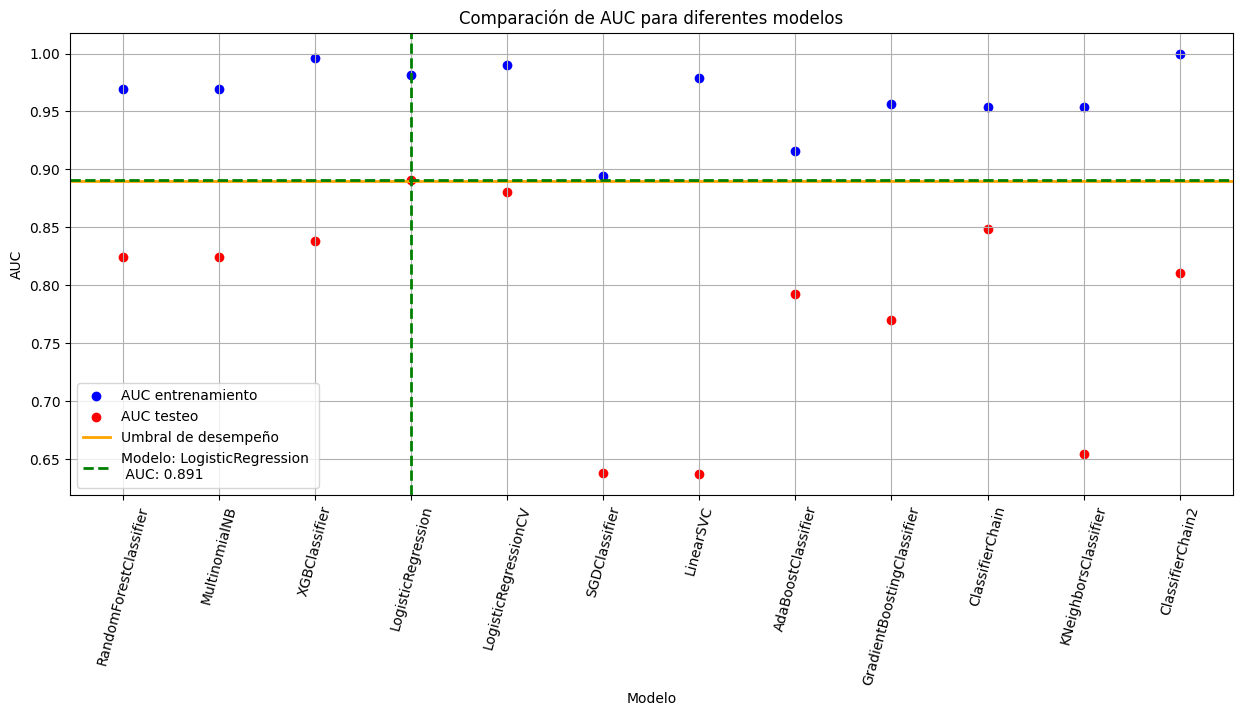

In [19]:
grafico_metricas(metricas_tabla)

In [20]:
print('Ok_')

Ok_
